# Community Detection in Hypergraph Networks

## Workbench

In [1]:
import numpy as np
import scipy.sparse as ssp
import random
from collections import Counter
from scipy.sparse.linalg import eigsh
import pandas as pd
from multiprocessing import Pool, cpu_count
from functools import partial, reduce
from sklearn.manifold import TSNE
from itertools import permutations, combinations, combinations_with_replacement 
from math import factorial

In [2]:
%matplotlib inline
import pylab as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [3]:
from bokeh.io import output_notebook, show, save
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [4]:
def get_nodes(x,G):
    return tuple(sorted(G[x,:].nonzero()[1]))
    
def get_hyperedges(G):
    # G: a edge-by-node incidence matrix
    with Pool(cpu_count()-1) as pool:
        E=Counter(pool.map(partial(get_nodes,G=G), (G.sum(axis=1).A.flatten()>1).nonzero()[0]))
    pool.close()
    pool.join()
    return E.keys()

def get_incidence(edges):
    indices=[]
    indptr=[0]
    for e in edges:
        indptr.append(indptr[-1]+len(e))
        indices+=list(e)
    return ssp.csr_matrix((np.ones(indptr[-1]), indices, indptr))

def load_edges(filename, sep='\t'):
    data=pd.read_csv(filename,sep)
    return ssp.csr_matrix((np.ones(len(data)),zip(*data.values)),shape=data.max().values+1)

In [5]:
# Given an edge-by-node incidence matrix, this function returns the submatrix corresponding to the largest connected component. 
# If the associated adjacency matrix is weighted, edges with weights less than the threshold will be removed before finding components.
def largest_component(G,threshold=None):
    P=G.T*G
    if threshold is None:
        weights=Counter(P.data)
        t=input("Tell me where to cut. Edges with weights >= will be kept. Here is the distribution of weights:\n{}".format(weights))
    else:
        t=threshold
    for i in range(1,t):
        P[P==i]=0
        P.eliminate_zeros()
    _,comp=ssp.csgraph.connected_components(P, directed=False)
    largest_comp=Counter(comp).most_common(1)[0]
    nodes=(comp==largest_comp[0]).nonzero()[0]
    G2=G[:,nodes]
    edges=G2.sum(axis=1).nonzero()[0]
    return G2[edges,:], nodes, edges

## Stochastic Block Model

* Given an order-$m$ hypergraph with $N$ nodes and $M$ hyperedges (edges for short). 
* Let $A$ be the order-$m$ adjacency tensor.  
* The stochastic block model for hypergraphs (SBMH) is defined as follows:
 * The nodes are divided into $K$ disjoint communities, $V=V_1\cap V_2 \cap \cdots \cap V_K$.
 * The probability that nodes $i_1,\cdots,i_m$ will form an edge is 
$$P(A[i_1,\cdots,i_m]=1) = C[g(i_1),\cdots,g(i_m)]\prod_{j\in\{i_1,\cdots,i_m\}}\theta_j,$$
where $g(i)$ is the community that node $i$ belongs to, and $\theta_i$ is a connectivity paramter for $i$.
 * $C$ is also an order-$m$ tensor and $C[g_1,\cdots,g_m]$ is the "density" of edges between communities $g_1,\cdots,g_m$. $C$ is much smaller than $A$.
* Let $Q$ be the tensor where $Q[i_1,\cdots,i_m]= P(A[i_1,\cdots,i_m]=1)$, $1\leq i_1,\cdots,i_m \leq N$, and $B$ be the matrix where $B[i,k]=1$ if node $i$ is in community $k$.
* Then SBMH can be written as
$$Q[i_1,\cdots,i_m] = \sum_{g_1,\cdots,g_m} C[g_1,\cdots,g_m] \theta_{i_1}B[i_1,g_1] \cdots \theta_{i_m} B[i_m,g_m].$$
* In tensor form, $Q = [C; \theta B, \cdots, \theta B]$.
* In other words, the SBMH assumes that the adjacency tensor can be approximated by a Tucker decomposition $[C; \theta B, \cdots, \theta B]$. 

In [6]:
# This function generate a hypergraph (actually, all hyperedges) from the SBM with the following C: the diagonal elements of C = pwithin and the off-diagonal elements of C = pbetween
def generate(N,M,m,comm,pwithin,pbetween):
    V=range(N)
    edges=set()
    typecount=[0,0]
    while len(edges)<M:
        v=random.sample(V,m)
        if len(np.unique(comm[v]))>1:
            p=pbetween
            t=1
        else:
            p=pwithin
            t=0
        if random.random()<=p:
            edges.add(tuple(sorted(v)))
            typecount[t]+=1
    print("between: {}, within: {}".format(typecount[1],typecount[0]) )
    return list(edges)

## Hyper-SCORE

Given a hypergraph, hyper-SCORE fits the SBM to data and infers the community membership of nodes.
1. Perform a Tucker decomposition of the adjacency tensor $A$.
    1. Higher-order SVD (HOSVD) of $A$ as the initial decomposition. 
        1. Obtain the mode-1 matrix $A^{(1)}$ of $A$ by mapping indices as the following: $$A^{(1)}[i_1, \sum_{j=2}^m i_j N^{m-j}] = A[i_1,\cdots,i_m].$$
        2. Compute the $K$ left singular vectors $(u_1,\cdots,u_K)$ of $A^{(1)}$ corresponding to the $K$ largest singular values. 
            * If $A^{(1)}$ is too wide ($N$ by $N^{m-1}$) to do SVD, compute the eigen vectors of $A^{(1)}A^{(1)^T}$, since $A^{(1)}A^{(1)^T}$ can be much smaller than $A^{(1)}$ and can be calculated without constructing $A^{(1)}$ explicitely as follows.
            * Let $e_i$ ($e_j$) be an edge that contains $i$ ($j$), and $e_i - i$ be the set of nodes after removing $i$ from $e_i$. 
            * $[A^{(1)}A^{(1)^T}]_{ij}$ = number of pairs $(e_i, e_j)$ s.t. $e_i - i$ = $e_j - j$, for any $e_i, e_j$.
    2. Higher-order orthogonal iteration for improvements.
        1. Let $U=[u_1,\cdots,u_K]$. (Use the leading sigular vectors from HOSVD in the first iteration.)  
        2. Compute $$C[i_1, g_2, \cdots, g_m]=\sum_{i_2,\cdots,i_m} A[i_1,i_2,\cdots,i_m] U[i_2,g_2] \cdots U[i_m,g_m], 1\leq i_1,\cdots,i_m \leq N, 1\leq g_2, \cdots, g_m \leq K.$$
        3. Calculate the $K$ leading left singular vectors $(u_1,\cdots,u_K)$ of $C^{(1)}$, the mode-1 matrization of $C$.
        4. Repeat all steps above until convergence.
2. Compute $b_i=u_{i+1}/u_1$, $i=1,\cdots,K-1$.
3. Partition the rows of the matrix $[b_1,\cdots,b_{K-1}]$ with any clustering algorithm, e.g., k-means.

In [7]:
def count(x):
    return Counter([tuple(i) for i in x])

def preduce(A):
    chunks=cpu_count()-1
    with Pool(chunks) as pool:
        res=pool.map(count, np.array_split(A,chunks,axis=0))
    return reduce(lambda x,y:x+y, res)

In [8]:
from numba import guvectorize
from numba import int64,float64
from numba import cuda

MAX_EDGE=10

@guvectorize([(int64[:],int64[:,:],int64[:])], '(N),(M,m)->(N)',target='cuda')
def hosvd_matrization_gpu(pair,T,res):
    i=pair[0]
    j=pair[1]
    for k in range(len(res)):
        res[k]=-1
    end=T.shape[1]
    indxi=0
    indxj=0
    ei=T[i,:]
    ej=T[j,:]
    overlap=cuda.local.array(MAX_EDGE,int64)
    v=0
    for k in range(end):
        overlap[k]=-1
        v+=k
    csame=0
    while indxi<end and indxj<end:
        if ei[indxi]==ej[indxj]:
            overlap[indxi]=indxj
            csame+=1
            indxi+=1
            indxj+=1
        elif ei[indxi]>ej[indxj]:
            indxj+=1
        else:
            indxi+=1
    if csame==(end-1):
        for k in range(len(overlap)):
            if overlap[k]==-1:
                u=ei[k]
            else:
                v-=overlap[k]
        v=ej[v]
        if u<v:
            res[0]=u
            res[1]=v
        else:
            res[0]=v
            res[1]=u

def hosvd_gpu(N,K,hyperedges,v0=None,N_dummies=0):
    M=len(hyperedges)
    m=len(hyperedges[0])
    T=cuda.to_device(np.array(hyperedges))
    indices=hosvd_matrization_gpu(list(combinations(range(M),2)),T)
    indices=indices.copy_to_host()
    indices=preduce(indices)
    del indices[(-1,-1)]
    
    H=ssp.coo_matrix((list(indices.values()),zip(*(indices.keys()))),shape=(N+N_dummies,N+N_dummies),dtype=float)
    H=H+H.T
    if N_dummies>0:
        H=H[:N,:]
        H=H[:,:N]
    _,U=eigsh(H,K,v0=v0)

    return U

@guvectorize([(int64[:],int64[:,:],float64[:,:],int64[:,:],float64[:])], '(m1),(M,m),(N,K),(p,m1)->(N)',target='cuda')
def tucker_matrization_gpu(km, T, U, permute, res):
    m=T.shape[1]
    for i in range(len(res)):
        res[i]=0
    for i in range(T.shape[0]):
        for j in range(m):
            im=cuda.local.array(MAX_EDGE,int64)
            k=0
            for l in range(m):
                if l!=j:
                    im[k]=T[i,l]
                    k+=1
            for p in range(permute.shape[0]):
                prod=1.0
                for k in range(m-1):
                    prod*=U[im[permute[p,k]],km[k]]
                res[T[i,j]]+=prod
                
def tucker_gpu(N, K, edges, U0,iterations=10, diagnose=True):
    m=len(edges[0])
    U_prev=U0
    U_new=U0
    permute=np.array(list(permutations(range(m-1))))
    permute=cuda.to_device(permute)
    T=cuda.to_device(np.array(edges))
    for iteration in range(iterations):
        T2=tucker_matrization_gpu(list(combinations_with_replacement(range(K), m-1)),T,U_prev,permute)
        T2=T2.copy_to_host()
        T2=T2.T
        U_new,_,_=ssp.linalg.svds(T2,k=K)
        if diagnose:
            print("Iteration: {}, Difference: {}".format(iteration, np.linalg.norm(abs(U_new)-abs(U_prev))), flush=True)
        U_prev=U_new
    return U_new

def hyper_score_gpu(N,K,hyperedges,eigs=False,v0=None,iterations=10,diagnose=True):
    U=hosvd_gpu(N,K,hyperedges,v0=v0)
    if iterations>0:
        U=tucker_gpu(N, K, hyperedges, U,iterations,diagnose)  
    if eigs:
        return U
    x=U[:,-1]
    d=(x==0)
    x[d]=1
    B = U[:,:-1]/x.reshape(len(U),1)
    B[d,:]=B.max()
    return B

In [9]:
def score(G,K,eigs=False,project='normalized'):
    if project not in ['binary', 'sum', 'normalized']:
        raise ValueError("Invalid projection type.")
    if project=='normalized':
        d=G.sum(axis=1).A.flatten()
        d=1/d
        D=ssp.diags(d)
        A=G.T*D*D*G
    else:
        A=G.T*G
    if project is 'binary':
        A.data=np.ones_like(A.data)
    _,U=eigsh(A,K)
    if eigs:
        return U
    B = U[:,:-1]/U[:,-1].reshape(len(U),1)
    return B

### Non-uniform Hypergraphs

If the hypergraph is not uniform (not all the hyperedges are of the same size), make all the hyperedges the same size by adding dummy nodes.

In [10]:
def homogenize(N,m,edges,max_size=None):
    if max_size is None:
        max_size=m
    min_size=m
    for e in edges:
        if (len(e)!=1 and len(e)<min_size):
            min_size=len(e)
    dummies=np.ones(m-min_size)*N + np.arange(m-min_size)
    dummies=tuple(dummies.astype(int))
    newedges=set()
    for e in edges:
        if len(e)<=1 or len(e)>max_size:
            continue
        if len(e)>m:
            for i in combinations(e,m):
                newedges.add(i)
        elif len(e)==m:
            newedges.add(e)
        else:
            newedges.add(e+dummies[len(e)-min_size:])
    return len(dummies), list(newedges)

##  Synthetic Data

Hypergraph generated from the SBM, with $N$ nodes, $M$ edges of size $m$, and $K$ communities. 

In [11]:
N=100
M=500
m=3
K=2
comm=np.zeros(N)
comm[50:]=1
pwithin=0.9
pbetween=0.1

In [12]:
edges = generate(N,M,m,comm,pwithin,pbetween)

between: 138, within: 363


HOSVD

In [13]:
U0 = hosvd_gpu(N,K,edges)
B0 = U0[:,:-1]/U0[:,-1].reshape(len(U0),1)

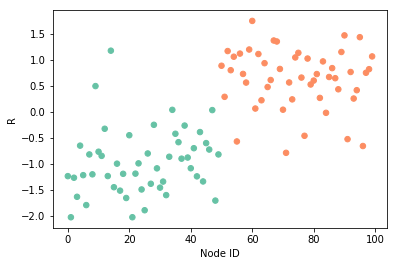

In [16]:
plt.scatter(range(len(B0)), B0, s=30,c=comm, cmap=ListedColormap(sns.color_palette("Set2", 2)));
plt.xlabel('Node ID');
plt.ylabel('R');

Tucker decomposition

In [15]:
B=hyper_score_gpu(N,K,edges,iterations=20)

Iteration: 0, Difference: 0.8738867808119022
Iteration: 1, Difference: 0.442693811434662
Iteration: 2, Difference: 0.25061068682318427
Iteration: 3, Difference: 0.15989622955055616
Iteration: 4, Difference: 0.10427794701393789
Iteration: 5, Difference: 0.06995649306581295
Iteration: 6, Difference: 0.04732302574370703
Iteration: 7, Difference: 0.03238978144430731
Iteration: 8, Difference: 0.022372708818385243
Iteration: 9, Difference: 0.015589861355829945
Iteration: 10, Difference: 0.010946103952717829
Iteration: 11, Difference: 0.007741823686036135
Iteration: 12, Difference: 0.00550910401818849
Iteration: 13, Difference: 0.00394399255765829
Iteration: 14, Difference: 0.0028365416389858297
Iteration: 15, Difference: 0.0020501555532838173
Iteration: 16, Difference: 0.001486479206264085
Iteration: 17, Difference: 0.0010822488598917195
Iteration: 18, Difference: 0.0007894142537298776
Iteration: 19, Difference: 0.0005779409852807557


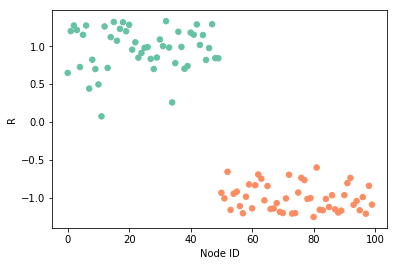

In [17]:
plt.scatter(range(len(B)), B, s=30,c=comm, cmap=ListedColormap(sns.color_palette("Set2", 2)));
plt.xlabel('Node ID');
plt.ylabel('R');

Project to simple graph and do SCORE

In [19]:
G=get_incidence(edges)

In [20]:
B2=score(G,K)

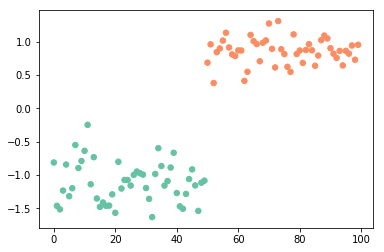

In [21]:
plt.scatter(range(len(B2)), B2, s=30,c=comm, cmap=ListedColormap(sns.color_palette("Set2", 2)));

## Real Data

### Statistician Network

* Edges: papers published in the statistics journals.
* Nodes: authors of the papers.

In [42]:
G=load_edges('../Data/statistician.tsv')
node_names=pd.read_csv('../Data/statistician_names.csv',sep='\t')
node_names.columns=['node_id','name']

In [43]:
G2, nodes, _=largest_component(G,2)
N=G2.shape[1]

In [44]:
node_names=node_names.merge(pd.DataFrame({"node_id":nodes}), on='node_id')

In [45]:
edges=get_hyperedges(G2)

In [46]:
print("Distribution of edge sizes:")
print(sorted(Counter([len(i) for i in edges]).items()))

Distribution of edge sizes:
[(2, 207), (3, 124), (4, 20), (6, 1)]


Add dummy nodes to make all edges of size $m$

In [47]:
m=4
dummies,regular_edges=homogenize(N,m,edges)

Set the number of communities $K$ and do HOSVD

In [62]:
K=3
U0 = hosvd_gpu(N+dummies,K,regular_edges)
B0 = U0[:,:-1]/U0[:,-1].reshape(len(U0),1)

Visualization of HOSVD Result

In [63]:
source = ColumnDataSource(
        data=dict(
            x=B0[:N,0],
            y=B0[:N,1],
            desc=node_names['name'],
            s=np.log(G2.sum(axis=0).A.ravel()+1)*5
        )
    )

hover = HoverTool(
        tooltips=[
            ("", "@desc"),
        ]
    )

p = figure(plot_width=750, plot_height=500)

p.circle('x', 'y', size='s', source=source, fill_alpha=0.5)
p.add_tools(hover)
show(p)

Full Tucker decomposition

In [64]:
B=hyper_score_gpu(N+dummies,K,regular_edges,iterations=20)

Iteration: 0, Difference: 2.0416923786738463
Iteration: 1, Difference: 2.1470508625915032
Iteration: 2, Difference: 2.335812773580966
Iteration: 3, Difference: 2.2976960198376655
Iteration: 4, Difference: 2.233147512395506
Iteration: 5, Difference: 2.039360728400122
Iteration: 6, Difference: 1.0518379749105227
Iteration: 7, Difference: 1.0125450412398511
Iteration: 8, Difference: 0.9526473575797249
Iteration: 9, Difference: 0.9211162651386323
Iteration: 10, Difference: 0.893198008134127
Iteration: 11, Difference: 0.9936032946719194
Iteration: 12, Difference: 0.9625867484709886
Iteration: 13, Difference: 0.8394179541205792
Iteration: 14, Difference: 1.0572300025719095
Iteration: 15, Difference: 0.838439815889755
Iteration: 16, Difference: 0.7560899357880334
Iteration: 17, Difference: 0.7606341110882439
Iteration: 18, Difference: 0.8043573665993209
Iteration: 19, Difference: 1.0679202421027139


Visualization of Tucker result

In [65]:
source = ColumnDataSource(
        data=dict(
            x=B[:N,0],
            y=B[:N,1],
            desc=node_names['name'],
            s=np.log(G2.sum(axis=0).A.ravel()+1)*5
        )
    )

hover = HoverTool(
        tooltips=[
            ("", "@desc"),
        ]
    )

p = figure(plot_width=750, plot_height=500)

p.circle('x', 'y', size='s', source=source, fill_alpha=0.5)
p.add_tools(hover)
show(p)

Project to simple graph and do SCORE

In [66]:
B2=score(G2,K,project='binary')

In [67]:
source = ColumnDataSource(
        data=dict(
            x=B2[:N,0],
            y=B2[:N,1],
            desc=node_names['name'],
            s=np.log(G2.sum(axis=0).A.ravel()+1)*5
        )
    )

hover = HoverTool(
        tooltips=[
            ("", "@desc"),
        ]
    )

p = figure(plot_width=750, plot_height=500)

p.circle('x', 'y', size='s', source=source, fill_alpha=0.5)
p.add_tools(hover)
show(p)

### Legislator Network

* Edges: bills proposed in the congress of Peru.
* Nodes: congressmen of Peru.

In [11]:
G=load_edges('../Data/legislator.csv')
N=G.shape[1]

In [12]:
df=pd.read_csv('../Data/legislator_party.csv',sep='\t')
comm=np.zeros(N,dtype=int)
comm[df['node_id']]=df['party_id']

In [13]:
edges=get_hyperedges(G)

In [14]:
print("Distribution of edge sizes:")
print(sorted(Counter([len(i) for i in edges]).items()))

Distribution of edge sizes:
[(2, 19), (3, 5), (4, 14), (5, 15), (6, 805), (7, 743), (8, 446), (9, 245), (10, 142), (11, 104), (12, 60), (13, 53), (14, 41), (15, 34), (16, 26), (17, 17), (18, 16), (19, 8), (20, 8), (21, 4), (22, 6), (23, 1), (24, 3), (25, 2), (26, 2), (27, 1), (28, 1), (29, 2), (31, 1), (33, 1), (34, 1), (40, 1), (49, 1), (60, 1), (65, 1)]


Add dummy nodes to make all edges of size $m$

In [15]:
m=6
dummies,regular_edges=homogenize(N,m,edges,8)

Set the number of communities $K$ and do HOSVD

In [18]:
K=7
U0 = hosvd_gpu(N+dummies,K,regular_edges)
B0 = U0[:,:-1]/U0[:,-1].reshape(len(U0),1)

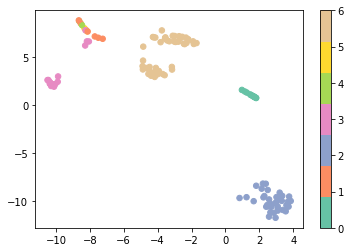

In [19]:
pos = TSNE(n_components=2).fit_transform(B0[:N,:])
plt.scatter(pos[:N,0],pos[:N,1],s=30,c=comm, cmap=ListedColormap(sns.color_palette("Set2", 7)));
plt.colorbar();

This network is too large for a full Tucker decomposition (not enough memory)

In [ ]:
B=hyper_score_gpu(N+dummies,K,regular_edges,iterations=20)

Compare with SCORE on the graph projection of the hypergraph

In [20]:
B2=score(G,K,project='binary')

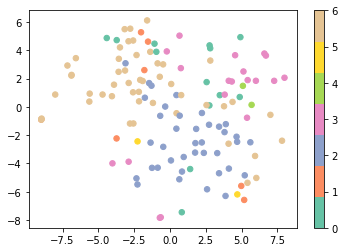

In [21]:
pos = TSNE(n_components=2).fit_transform(B2)
plt.scatter(pos[:,0],pos[:,1],s=30,c=comm, cmap=ListedColormap(sns.color_palette("Set2", 7)));
plt.colorbar();

### Institution Network

* Edges: papers published in the APS journals in 2012.
* Nodes: affiliations (intitutions) of the authors in the papers.

In [21]:
G=load_edges('../Data/aps2012.csv')
node_names=pd.read_csv('../Data/aps_name_2012.csv',sep='\t')

In [23]:
G2, nodes, _=largest_component(G,2)
N=G2.shape[1]

In [24]:
node_names=node_names.merge(pd.DataFrame({"node_id":nodes}), on='node_id')

In [25]:
edges=get_hyperedges(G2)

In [27]:
print("Distribution of edge sizes:")
print(sorted(Counter([len(i) for i in edges]).items()))

Distribution of edge sizes:
[(2, 1750), (3, 2031), (4, 1598), (5, 1070), (6, 560), (7, 312), (8, 178), (9, 96), (10, 56), (11, 38), (12, 18), (13, 23), (14, 8), (15, 10), (16, 9), (17, 5), (18, 2), (19, 2), (20, 6), (21, 1), (22, 1), (23, 3), (27, 3), (28, 2), (31, 1), (32, 1), (34, 1), (36, 1), (37, 1), (44, 1)]


Add dummy nodes to make all edges of size $m$

In [28]:
m=10
dummies,regular_edges=homogenize(N,m,edges)

Set the number of communities $K$ and do HOSVD

In [29]:
K=5
U0 = hosvd_gpu(N+dummies,K,regular_edges)
B0 = U0[:,:-1]/U0[:,-1].reshape(len(U0),1)

Project nodes from the $K-1$ space to 2D using t-SNE for visualization

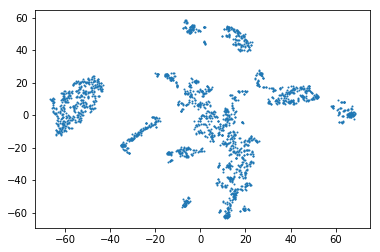

In [30]:
pos = TSNE(n_components=2).fit_transform(B0[:N,:])
plt.scatter(pos[:N,0],pos[:N,1],s=1);

In [34]:
source = ColumnDataSource(
        data=dict(
            x=pos[:N,0],
            y=pos[:N,1],
            desc=node_names['name'],
        )
    )

hover = HoverTool(
        tooltips=[
            ("", "@desc"),
        ]
    )

p = figure(plot_width=750, plot_height=500)

p.circle('x', 'y', size=5, source=source, fill_alpha=0.5)
p.add_tools(hover)
show(p)

This network is too large for a full Tucker decomposition (not enough memory)

In [ ]:
#B=hyper_score_gpu(N+dummies,K,regular_edges,iterations=20)

Compare with SCORE on the graph projection of the hypergraph

In [35]:
B2=score(G,K,project='binary')

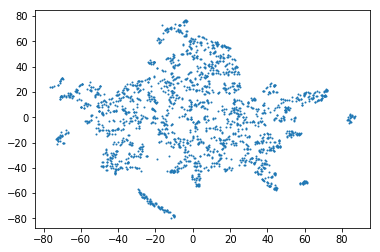

In [37]:
pos = TSNE(n_components=2).fit_transform(B2)
plt.scatter(pos[:N,0],pos[:N,1],s=1);

In [38]:
source = ColumnDataSource(
        data=dict(
            x=pos[:N,0],
            y=pos[:N,1],
            desc=node_names['name'],
        )
    )

hover = HoverTool(
        tooltips=[
            ("", "@desc"),
        ]
    )

p = figure(plot_width=750, plot_height=500)

p.circle('x', 'y', size=5, source=source, fill_alpha=0.5)
p.add_tools(hover)
show(p)

### Clinical Trials

* Edges: clinical trials from ClinicalTrials.org.
* Nodes: molecules (treatments) used by the trials.

In [11]:
G=load_edges('../Data/trials.tsv',sep='\t')

In [12]:
G2, nodes, _=largest_component(G,2)
N=G2.shape[1]

In [23]:
node_names=pd.read_csv('../Data/mesh2id.tsv',sep='\t')

In [25]:
node_names.columns=['name','node_id']

In [26]:
node_names=node_names.merge(pd.DataFrame({"node_id":nodes}), on='node_id')

In [15]:
edges=get_hyperedges(G2)

In [16]:
print("Distribution of edge sizes:")
print(sorted(Counter([len(i) for i in edges]).items()))

Distribution of edge sizes:
[(2, 8849), (3, 7732), (4, 5038), (5, 3390), (6, 2181), (7, 1429), (8, 936), (9, 639), (10, 391), (11, 295), (12, 198), (13, 141), (14, 94), (15, 74), (16, 37), (17, 34), (18, 28), (19, 12), (20, 13), (21, 14), (22, 14), (23, 12), (24, 8), (25, 10), (26, 2), (27, 2), (28, 4), (30, 4), (31, 4), (32, 4), (33, 1), (34, 1), (37, 1), (38, 1), (39, 1), (41, 1), (88, 1), (110, 1)]


Add dummy nodes to make all edges of size $m$

In [17]:
m=4
dummies,regular_edges=homogenize(N,m,edges)

Set the number of communities $K$ and do HOSVD

In [18]:
K=5
U0 = hosvd_gpu(N+dummies,K,regular_edges)
B0 = U0[:,:-1]/U0[:,-1].reshape(len(U0),1)

Project nodes from the $K-1$ space to 2D using t-SNE for visualization

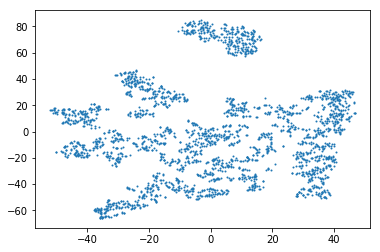

In [19]:
pos = TSNE(n_components=2).fit_transform(B0[:N,:])
plt.scatter(pos[:N,0],pos[:N,1],s=1);

In [27]:
source = ColumnDataSource(
        data=dict(
            x=pos[:N,0],
            y=pos[:N,1],
            desc=node_names['name'],
        )
    )

hover = HoverTool(
        tooltips=[
            ("", "@desc"),
        ]
    )

p = figure(plot_width=750, plot_height=500)

p.circle('x', 'y', size=5, source=source, fill_alpha=0.5)
p.add_tools(hover)
show(p)

This network is too large for a full Tucker decomposition (not enough memory)

In [ ]:
#B=hyper_score_gpu(N+dummies,K,regular_edges,iterations=20)

Compare with SCORE on the graph projection of the hypergraph

In [28]:
B2=score(G2,K,project='binary')

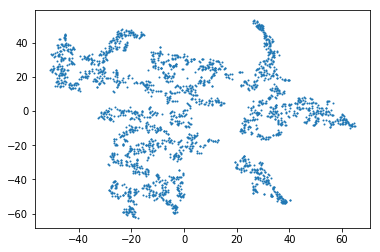

In [29]:
pos = TSNE(n_components=2).fit_transform(B2)
plt.scatter(pos[:N,0],pos[:N,1],s=1);

In [30]:
source = ColumnDataSource(
        data=dict(
            x=pos[:N,0],
            y=pos[:N,1],
            desc=node_names['name'],
        )
    )

hover = HoverTool(
        tooltips=[
            ("", "@desc"),
        ]
    )

p = figure(plot_width=750, plot_height=500)

p.circle('x', 'y', size=5, source=source, fill_alpha=0.5)
p.add_tools(hover)
show(p)